<a href="https://colab.research.google.com/github/TonCha1/Test-local-repo-ver-1/blob/main/SECOM_PYTHON_CODE_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:

"""
Perform data preprocessing steps as described:
    - Import libraries
    - Set required variables as global
    - Configure working directory
    - Load SECOM data and SECOM labels
    - Rename columns in SECOM data
    - Merge SECOM data and SECOM labels into one dataframe
    - Find columns with same values throughout
    - Plot histogram for each of the columns

"""
import os
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

def preprocess_secom_data():
    global secom_data, secom_labels_data, secom_main, rm_features, frequency_df, summary_df

    # Step 1: Configure working directory
    secom_data_url = 'https://raw.githubusercontent.com/dhirenrana93/SECOM_WIZARDS/main/secom.data'
    secom_labels_url = 'https://raw.githubusercontent.com/dhirenrana93/SECOM_WIZARDS/main/secom_labels.data'
    print("1. Current working directory from github:")
    print("1a. URL for secom data:",secom_data_url)
    print("1b. URL for secom labels:",secom_labels_url)
    print("\n")

    # Step 2: Load SECOM data and SECOM labels
    secom_data = pd.read_csv(secom_data_url, sep=' ', header=None)
    print("2. The shape of SECOM dataframe is ", secom_data.shape)
    print("\n")
    print("3. Sample SECOM data:")
    print(tabulate(secom_data.iloc[:2, :5], headers='keys', tablefmt='fancy_grid'))
    print("Note: Dataframe to be referred:secom_data")
    print("\n")

    secom_labels_data = pd.read_csv(secom_labels_url, sep=' ', header=None)
    print("4. The shape of SECOM labels dataframe is ", secom_labels_data.shape)
    print("\n")
    print("5. Sample SECOM labels data:")
    print(tabulate(secom_labels_data.iloc[:2, :5], headers='keys', tablefmt='fancy_grid'))
    print("Note: Dataframe to be referred:secom_labels_data")
    print("\n")

    # Step 3: Rename columns in SECOM dataframe
    new_column_names = [f'feature_{i}' for i in range(1, 591)]
    secom_data.columns = new_column_names
    secom_labels_data = secom_labels_data.rename(columns={0: 'pass_fail_flag', 1: 'timestamp'})

    # Step 4: Merge SECOM data and SECOM labels into one dataframe
    secom_main = pd.merge(secom_labels_data, secom_data, left_index=True, right_index=True)
    print("6. The shape of merged SECOM dataframe is ", secom_main.shape)
    print("\n")
    print("7. Sample merged SECOM data along with renamed column:")
    print(tabulate(secom_main.iloc[:2, :5], headers='keys', tablefmt='fancy_grid'))
    print("Note: Dataframe to be referred:secom_main")
    print("\n")

    # Step 5: Check features which have distinct records
    distinct_counts = []
    for column in secom_main.columns:
        distinct_count = secom_main[column].nunique()
        if distinct_count == 1:
            distinct_counts.append(column)
    rm_features = pd.DataFrame(distinct_counts, columns=['Feature'])
    print(f"8. {rm_features.shape[0]} features have the same value in the entire column and below are sample records:")
    print(tabulate(rm_features.head(10), headers='keys', tablefmt='fancy_grid'))
    print("Note: Dataframe to be referred:rm_features")
    print("\n")

    # Step 6: Descriptive statistics
    print("9. Descriptive statistics of all features:")

    # Function to calculate mode
    def calculate_mode(column):
        try:
            return column.mode().iloc[0]
        except IndexError:
            return np.nan

    # Function to calculate outlier percentage
    def calculate_outlier_percentage(column):
        mean = column.mean()
        std = column.std()
        mean_plus_3std = mean + 3 * std
        mean_minus_3std = mean - 3 * std
        outliers = ((column < mean_minus_3std) | (column > mean_plus_3std)).sum()
        total_points = len(column)
        return (outliers / total_points) * 100

    # Function to calculate coefficient of variation
    def calculate_coefficient_of_variation(column):
        mean = column.mean()
        std = column.std()
        if mean == 0:
            return np.nan
        return (std / mean) * 100

    # Calculate summary statistics for each column
    summary_data = []
    for column in secom_main.iloc[:, 2:593].columns:
        mean = secom_main[column].mean()
        median = secom_main[column].median()
        mode = calculate_mode(secom_main[column])
        std = secom_main[column].std()
        variance = secom_main[column].var()  # Calculate variance
        outlier_percentage = calculate_outlier_percentage(secom_main[column])
        coefficient_of_variation = calculate_coefficient_of_variation(secom_main[column])
        max_value = secom_main[column].max()
        min_value = secom_main[column].min()
        # Round the summary statistics to 4 decimal places
        mean = round(mean, 4)
        median = round(median, 4)
        mode = round(mode, 4) if not np.isnan(mode) else mode
        std = round(std, 4)
        variance = round(variance, 4)  # Round variance
        outlier_percentage = round(outlier_percentage, 4)
        coefficient_of_variation = round(coefficient_of_variation, 4)
        max_value = round(max_value, 4)
        min_value = round(min_value, 4)
        summary_data.append([column, mean, median, mode, variance, std, outlier_percentage, coefficient_of_variation, max_value, min_value])

    # Create DataFrame with the summary data
    summary_df = pd.DataFrame(summary_data, columns=['feature_name', 'mean', 'median', 'mode', 'var', 'sd', 'outlier_%', 'cov', 'max_val', 'min_val'])

    #Print output
    print(tabulate(summary_df.head(), headers='keys', tablefmt='fancy_grid'))

    print("Note: Dataframe to be referred:summary_df")
    print("\n")

    # Step 7: Plot histogram for each of the columns
    print("10. Histogram of volatilities of features")

    #Graph 1
    # Define the data and number of bins
    data = summary_df['var']
    num_bins = 20  # You can adjust the number of bins as needed

    # Create the histogram
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(data, bins=num_bins, color='skyblue', edgecolor='black', alpha=0.7)

    # Add count at the top of each bar
    for count, rect in zip(n, patches):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height + 0.5, f'{int(count)}', ha='center', va='bottom')

    # Add labels and title
    plt.title('Histogram of Variance')
    plt.xlabel('Variance')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Show the plot
    plt.show()
    print("\n")

    #Graph 2
    # Filter the data to include only values between 1 and 10000
    filtered_data = summary_df[(summary_df['var'] >= 100000) & (summary_df['var'] <= 50000000)]['var']

    # Define the number of bins
    num_bins = 20  # You can adjust the number of bins as needed

    # Create the histogram
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(filtered_data, bins=num_bins, color='skyblue', edgecolor='black', alpha=0.7)

    # Add count at the top of each bar
    for count, rect in zip(n, patches):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height + 0.5, f'{int(count)}', ha='center', va='bottom')

    # Add labels and title
    plt.title('Histogram of Variance (zoomed on the tail with value range 1e5 to 5e7)')
    plt.xlabel('Variance')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Show the plot
    plt.show()
    print("\n")

    #Graph 3
    # Define the data
    data = summary_df['var']

    # Define the bin edges using a logarithmic scale
    bins = np.logspace(np.log10(1), np.log10(42949271), num=50)  # Adjust the number of bins as needed

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

    # Set logarithmic scale for x-axis
    plt.xscale('log')

    # Add labels and title
    plt.title('Histogram of Variance (logarithmically spaced)')
    plt.xlabel('Variance')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Show the plot
    plt.show()
    print("\n")

    # Step 8: Find features with more than 55% missing values
    secom_main_no_nan = secom_main.replace({np.nan: None})
    missing_percentage_per_feature = (secom_main_no_nan.isnull().mean() * 100).round(2)
    missing_values_df = pd.DataFrame({'Percentage Missing': missing_percentage_per_feature})
    missing_values_greater_than_55_df = missing_values_df[missing_values_df['Percentage Missing'] > 55]

    # Sort the DataFrame by 'Percentage Missing' column in descending order
    missing_values_greater_than_55_df = missing_values_greater_than_55_df.sort_values(by='Percentage Missing', ascending=False)

    # Rename the index column as 'feature_name'
    missing_values_greater_than_55_df.index.name = 'feature_name'

    # Reset the index
    missing_values_greater_than_55_df.reset_index(inplace=True)

    # Print the DataFrame without the serial number column
    print("11. Features with more than 55% missing values:")
    print(tabulate(missing_values_greater_than_55_df[['feature_name', 'Percentage Missing']], headers='keys', tablefmt='fancy_grid'))
    print("\n")

    ## Step 9: Bar graph for missing values
    # Calculate the percentage of missing values for each feature
    missing_values = secom_main.isnull().mean() * 100

    # Define the number of bins
    num_bins = 20

    # Calculate the histogram
    counts, bin_edges = np.histogram(missing_values, bins=num_bins)

    # Plot a bar chart
    plt.figure(figsize=(10, 6))
    plt.hist(missing_values, bins=bin_edges, color='skyblue')
    plt.title('Distribution of Percentage of Missing Values Across Features')
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Count of Features')
    plt.grid(True)

    # Beautify x-axis labels
    plt.xticks(np.arange(0, 101, 5), rotation=45, ha='right')

    plt.tight_layout()

    # Annotate the counts on the bars
    for i in range(len(counts)):
        plt.text(bin_edges[i] + (bin_edges[i+1] - bin_edges[i]) / 2, counts[i],
                 f'{int(counts[i])}', ha='center', va='bottom')

    # Create a table to display the histogram data
    table_data = {'Bin Edges': bin_edges[:-1], 'Counts': counts}
    table_df = pd.DataFrame(table_data)
    plt.show()

    # Step 10: Frequency distribution of target values
    print("12. Frequency distribution of target values:")
    data_list = []
    for column in secom_main.columns:
        if column == 'timestamp':
            secom_main['timestamp'] = pd.to_datetime(secom_main['timestamp'])
            date_column = secom_main['timestamp'].dt.date
            date_distribution = date_column.value_counts()
            for date, frequency in date_distribution.items():
                data_list.append([date, frequency, column])
        else:
            column_distribution = secom_main[column].value_counts()
            for value, frequency in column_distribution.items():
                data_list.append([value, frequency, column])

    frequency_df = pd.DataFrame(data_list, columns=['value', 'frequency', 'feature_name'])
    print(tabulate(frequency_df.head(10), headers='keys', tablefmt='fancy_grid'))
    print("Note: Dataframe to be referred:frequency_df")
    print("\n")

    # Step 11: Correlation heatmap
    print("13. Correlation Heatmap:")

    # Calculate correlation matrix
    correlation_matrix = secom_main.iloc[:, 2:].corr()

    # Define the color map and range based on the attached image's color palette
    cmap = sns.color_palette("bright", as_cmap=True)
    vmin = 0   # Adjusted lower bound of color range based on image's scale
    vmax = 1    # Adjusted upper bound of color range based on image's scale

    # Determine the label size based on the number of columns
    label_size = min(max(20, 1000 // 590), 30)

    # Plot correlation heatmap with adjusted figsize and label size
    plt.figure(figsize=(50, 60))
    sns.heatmap(correlation_matrix, annot=False, cmap=cmap, vmin=vmin, vmax=vmax,
            fmt=".2f", linewidths=1, square=True,
            annot_kws={"size": label_size},
            cbar_kws={"shrink": 0.5})  # Adjust the size of the color bar
    plt.title('Correlation Heatmap')
    plt.show()

    # Create a DataFrame from high correlation pairs
    high_corr_pairs_df = correlation_matrix[abs(correlation_matrix) >= 0.8].stack()

    # Count pairs with correlation >= 0.8
    high_corr_pairs_count = high_corr_pairs_df.count()
    high_corr_pairs_count = (high_corr_pairs_count - 590)/2

    # Extract distinct features from high correlation pairs using set comprehension
    distinct_features = len({feature for pair in high_corr_pairs_df.index for feature in pair})

    print("Number of pairs with correlation >= 0.8:", high_corr_pairs_count)
    print("Number of distinct features in high correlation pairs:", distinct_features)


    print("\n")

    # Step 12: Distribution of variances
    # Assuming 'summary_df' has a column named 'var'
    low_threshold = 10  # Define low variance threshold
    high_threshold = 100000  # Define high variance threshold

    # Filter dataframes
    low_var_df = summary_df[summary_df['var'] <= low_threshold]
    medium_var_df = summary_df[(summary_df['var'] > low_threshold) & (summary_df['var'] <= high_threshold)]
    high_var_df = summary_df[summary_df['var'] > high_threshold]

    #Calculate percentage of feature in each of the range
    total_cnt = summary_df['var'].count()

    low_cnt= low_var_df['var'].count()
    low_cnt_percent = round(low_cnt/total_cnt*100)

    med_cnt= medium_var_df['var'].count()
    med_cnt_percent = round(med_cnt/total_cnt*100)

    high_cnt= high_var_df['var'].count()
    high_cnt_percent = round(high_cnt/total_cnt*100)

    # Create histograms (adjust figure size and labels as needed)
    plt.figure(figsize=(18, 6))  # Increased width for better visibility

    # Subplot 1 (low variance)
    plt.subplot(131)
    plt.hist(low_var_df['var'], bins=50, alpha=0.7,label=f"{low_cnt_percent:.2f}%", color = 'skyblue', edgecolor='black')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))  # Legend at left edge, top corner
    plt.xlabel("Variance", fontsize=14, color='black')
    plt.ylabel("Number of features", fontsize=14, color='black')
    plt.ylim(0, 350)

    # Subplot 2 (medium variance)
    plt.subplot(132)
    plt.hist(medium_var_df['var'], bins=50, alpha=0.7,label=f"{med_cnt_percent:.2f}%", color = 'skyblue', edgecolor='black')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))  # Legend at left edge, top corner
    plt.xlabel("Variance", fontsize=14, color='black')
    plt.ylabel("Number of features", fontsize=14, color='black')
    plt.ylim(0, 350)
    plt.xlim(10, 10000)  # Set x-axis range from 10 to 10000

    # Subplot 3 (high variance)
    plt.subplot(133)
    plt.hist(high_var_df['var'], bins=50, alpha=0.7,label=f"{high_cnt_percent:.2f}%", color = 'skyblue', edgecolor='black')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))  # Legend at left edge, top corner
    plt.xlabel("Variance (in millions)", fontsize=14, color='black')
    plt.ylabel("Number of features", fontsize=14, color='black')
    plt.ylim(0, 350)
    plt.xlim(0.5e6, high_var_df['var'].max())  # Set x-axis range from 0.5 million to the maximum value of 'var' in high_var_df

    # Set x-axis ticks in millions
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}M'.format(x * 1e-6)))

    plt.suptitle("Distribution of Variances", fontsize=14)
    plt.tight_layout()
    plt.show()

   #Step 13. Distribution of COV

   # Assuming 'summary_df' is your DataFrame and 'cov' is the column of interest
    num_bins = 20
    width = 10  # Adjust the width as needed
    height = 6
    plt.figure(figsize=(width, height))
    counts, bins, patches = plt.hist(summary_df['cov'], bins=num_bins, edgecolor='black')

    # Calculate the total number of values
    total_values = len(summary_df['cov'])

    # Iterate over each bin to add percentage labels
    for count, patch in zip(counts, patches):
        # Calculate percentage
        percentage = count / total_values * 100
        # Add the percentage label
        plt.text(patch.get_x() + patch.get_width() / 2, patch.get_height() + 0.5,
                f'{percentage:.2f}%', ha='center', va='bottom')

    # Customize plot appearance
    plt.title('Distribution of cov')
    plt.xlabel('cov')
    plt.ylabel('Frequency')
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.grid(True)
    plt.show()
    print("\n")


# Step 14: observation on distint values where there are more zeros in a feature

    val_grouping = frequency_df.groupby('feature_name').size().reset_index(name='count')
    val_grouping_main = frequency_df[frequency_df['feature_name'].isin(val_grouping.iloc[:, 0:1][(val_grouping['count'] == 2) & (val_grouping['feature_name'] != 'pass_fail_flag')]['feature_name'])]
    print(tabulate(val_grouping_main.head(10), headers='keys', tablefmt='fancy_grid'))

    print("\n")
    return


1. Current working directory from github:
1a. URL for secom data: https://raw.githubusercontent.com/dhirenrana93/SECOM_WIZARDS/main/secom.data
1b. URL for secom labels: https://raw.githubusercontent.com/dhirenrana93/SECOM_WIZARDS/main/secom_labels.data


2. The shape of SECOM dataframe is  (1567, 590)


3. Sample SECOM data:
╒════╤═════════╤═════════╤═════════╤═════════╤════════╕
│    │       0 │       1 │       2 │       3 │      4 │
╞════╪═════════╪═════════╪═════════╪═════════╪════════╡
│  0 │ 3030.93 │ 2564    │ 2187.73 │ 1411.13 │ 1.3602 │
├────┼─────────┼─────────┼─────────┼─────────┼────────┤
│  1 │ 3095.78 │ 2465.14 │ 2230.42 │ 1463.66 │ 0.8294 │
╘════╧═════════╧═════════╧═════════╧═════════╧════════╛
Note: Dataframe to be referred:secom_data


4. The shape of SECOM labels dataframe is  (1567, 2)


5. Sample SECOM labels data:
╒════╤═════╤═════════════════════╕
│    │   0 │ 1                   │
╞════╪═════╪═════════════════════╡
│  0 │  -1 │ 19/07/2008 11:55:00 │
├────┼─────┼─

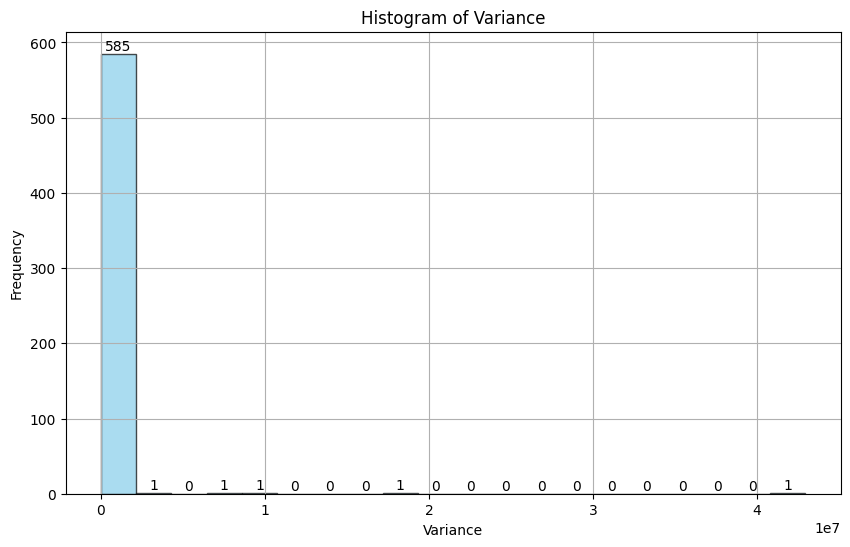

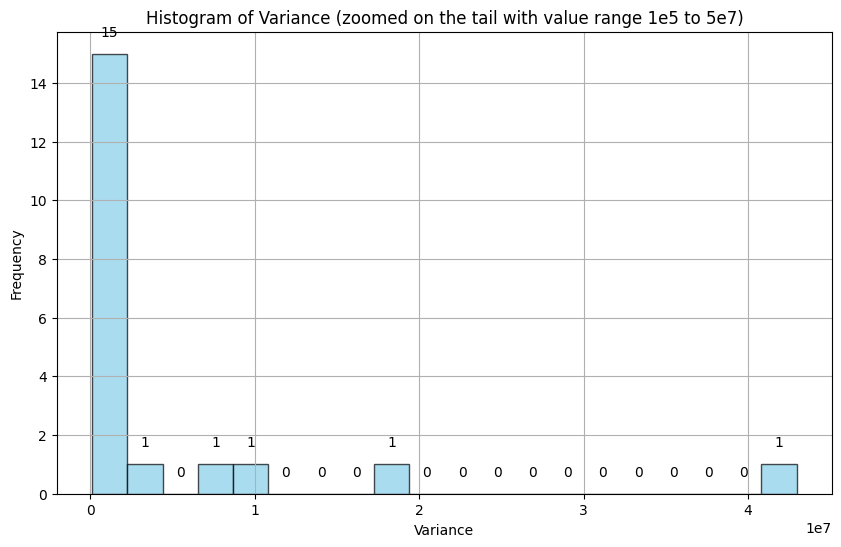

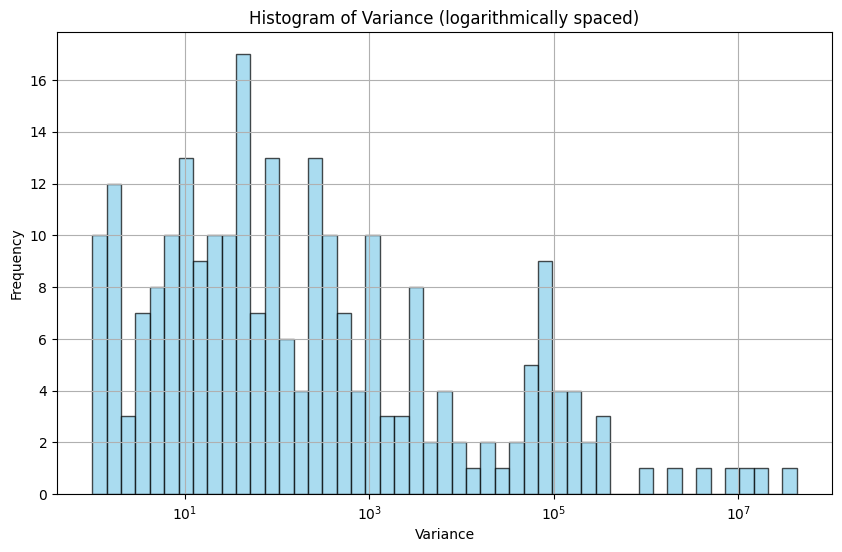



11. Features with more than 55% missing values:
╒════╤════════════════╤══════════════════════╕
│    │ feature_name   │   Percentage Missing │
╞════╪════════════════╪══════════════════════╡
│  0 │ feature_293    │                91.19 │
├────┼────────────────┼──────────────────────┤
│  1 │ feature_294    │                91.19 │
├────┼────────────────┼──────────────────────┤
│  2 │ feature_158    │                91.19 │
├────┼────────────────┼──────────────────────┤
│  3 │ feature_159    │                91.19 │
├────┼────────────────┼──────────────────────┤
│  4 │ feature_86     │                85.58 │
├────┼────────────────┼──────────────────────┤
│  5 │ feature_493    │                85.58 │
├────┼────────────────┼──────────────────────┤
│  6 │ feature_359    │                85.58 │
├────┼────────────────┼──────────────────────┤
│  7 │ feature_221    │                85.58 │
├────┼────────────────┼──────────────────────┤
│  8 │ feature_245    │                64.96 │
├────┼────

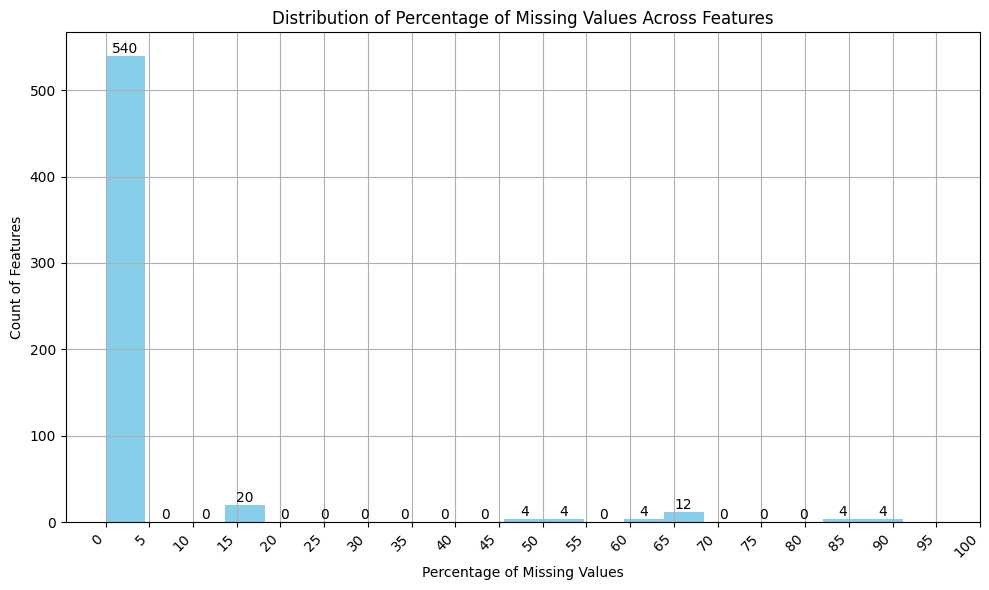

12. Frequency distribution of target values:


<ipython-input-36-d1d216a9f185>:273: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  secom_main['timestamp'] = pd.to_datetime(secom_main['timestamp'])


╒════╤════════════╤═════════════╤════════════════╕
│    │ value      │   frequency │ feature_name   │
╞════╪════════════╪═════════════╪════════════════╡
│  0 │ -1         │        1463 │ pass_fail_flag │
├────┼────────────┼─────────────┼────────────────┤
│  1 │ 1          │         104 │ pass_fail_flag │
├────┼────────────┼─────────────┼────────────────┤
│  2 │ 2008-09-02 │          62 │ timestamp      │
├────┼────────────┼─────────────┼────────────────┤
│  3 │ 2008-08-29 │          50 │ timestamp      │
├────┼────────────┼─────────────┼────────────────┤
│  4 │ 2008-08-30 │          49 │ timestamp      │
├────┼────────────┼─────────────┼────────────────┤
│  5 │ 2008-10-06 │          48 │ timestamp      │
├────┼────────────┼─────────────┼────────────────┤
│  6 │ 2008-08-21 │          44 │ timestamp      │
├────┼────────────┼─────────────┼────────────────┤
│  7 │ 2008-08-28 │          43 │ timestamp      │
├────┼────────────┼─────────────┼────────────────┤
│  8 │ 2008-08-22 │          40

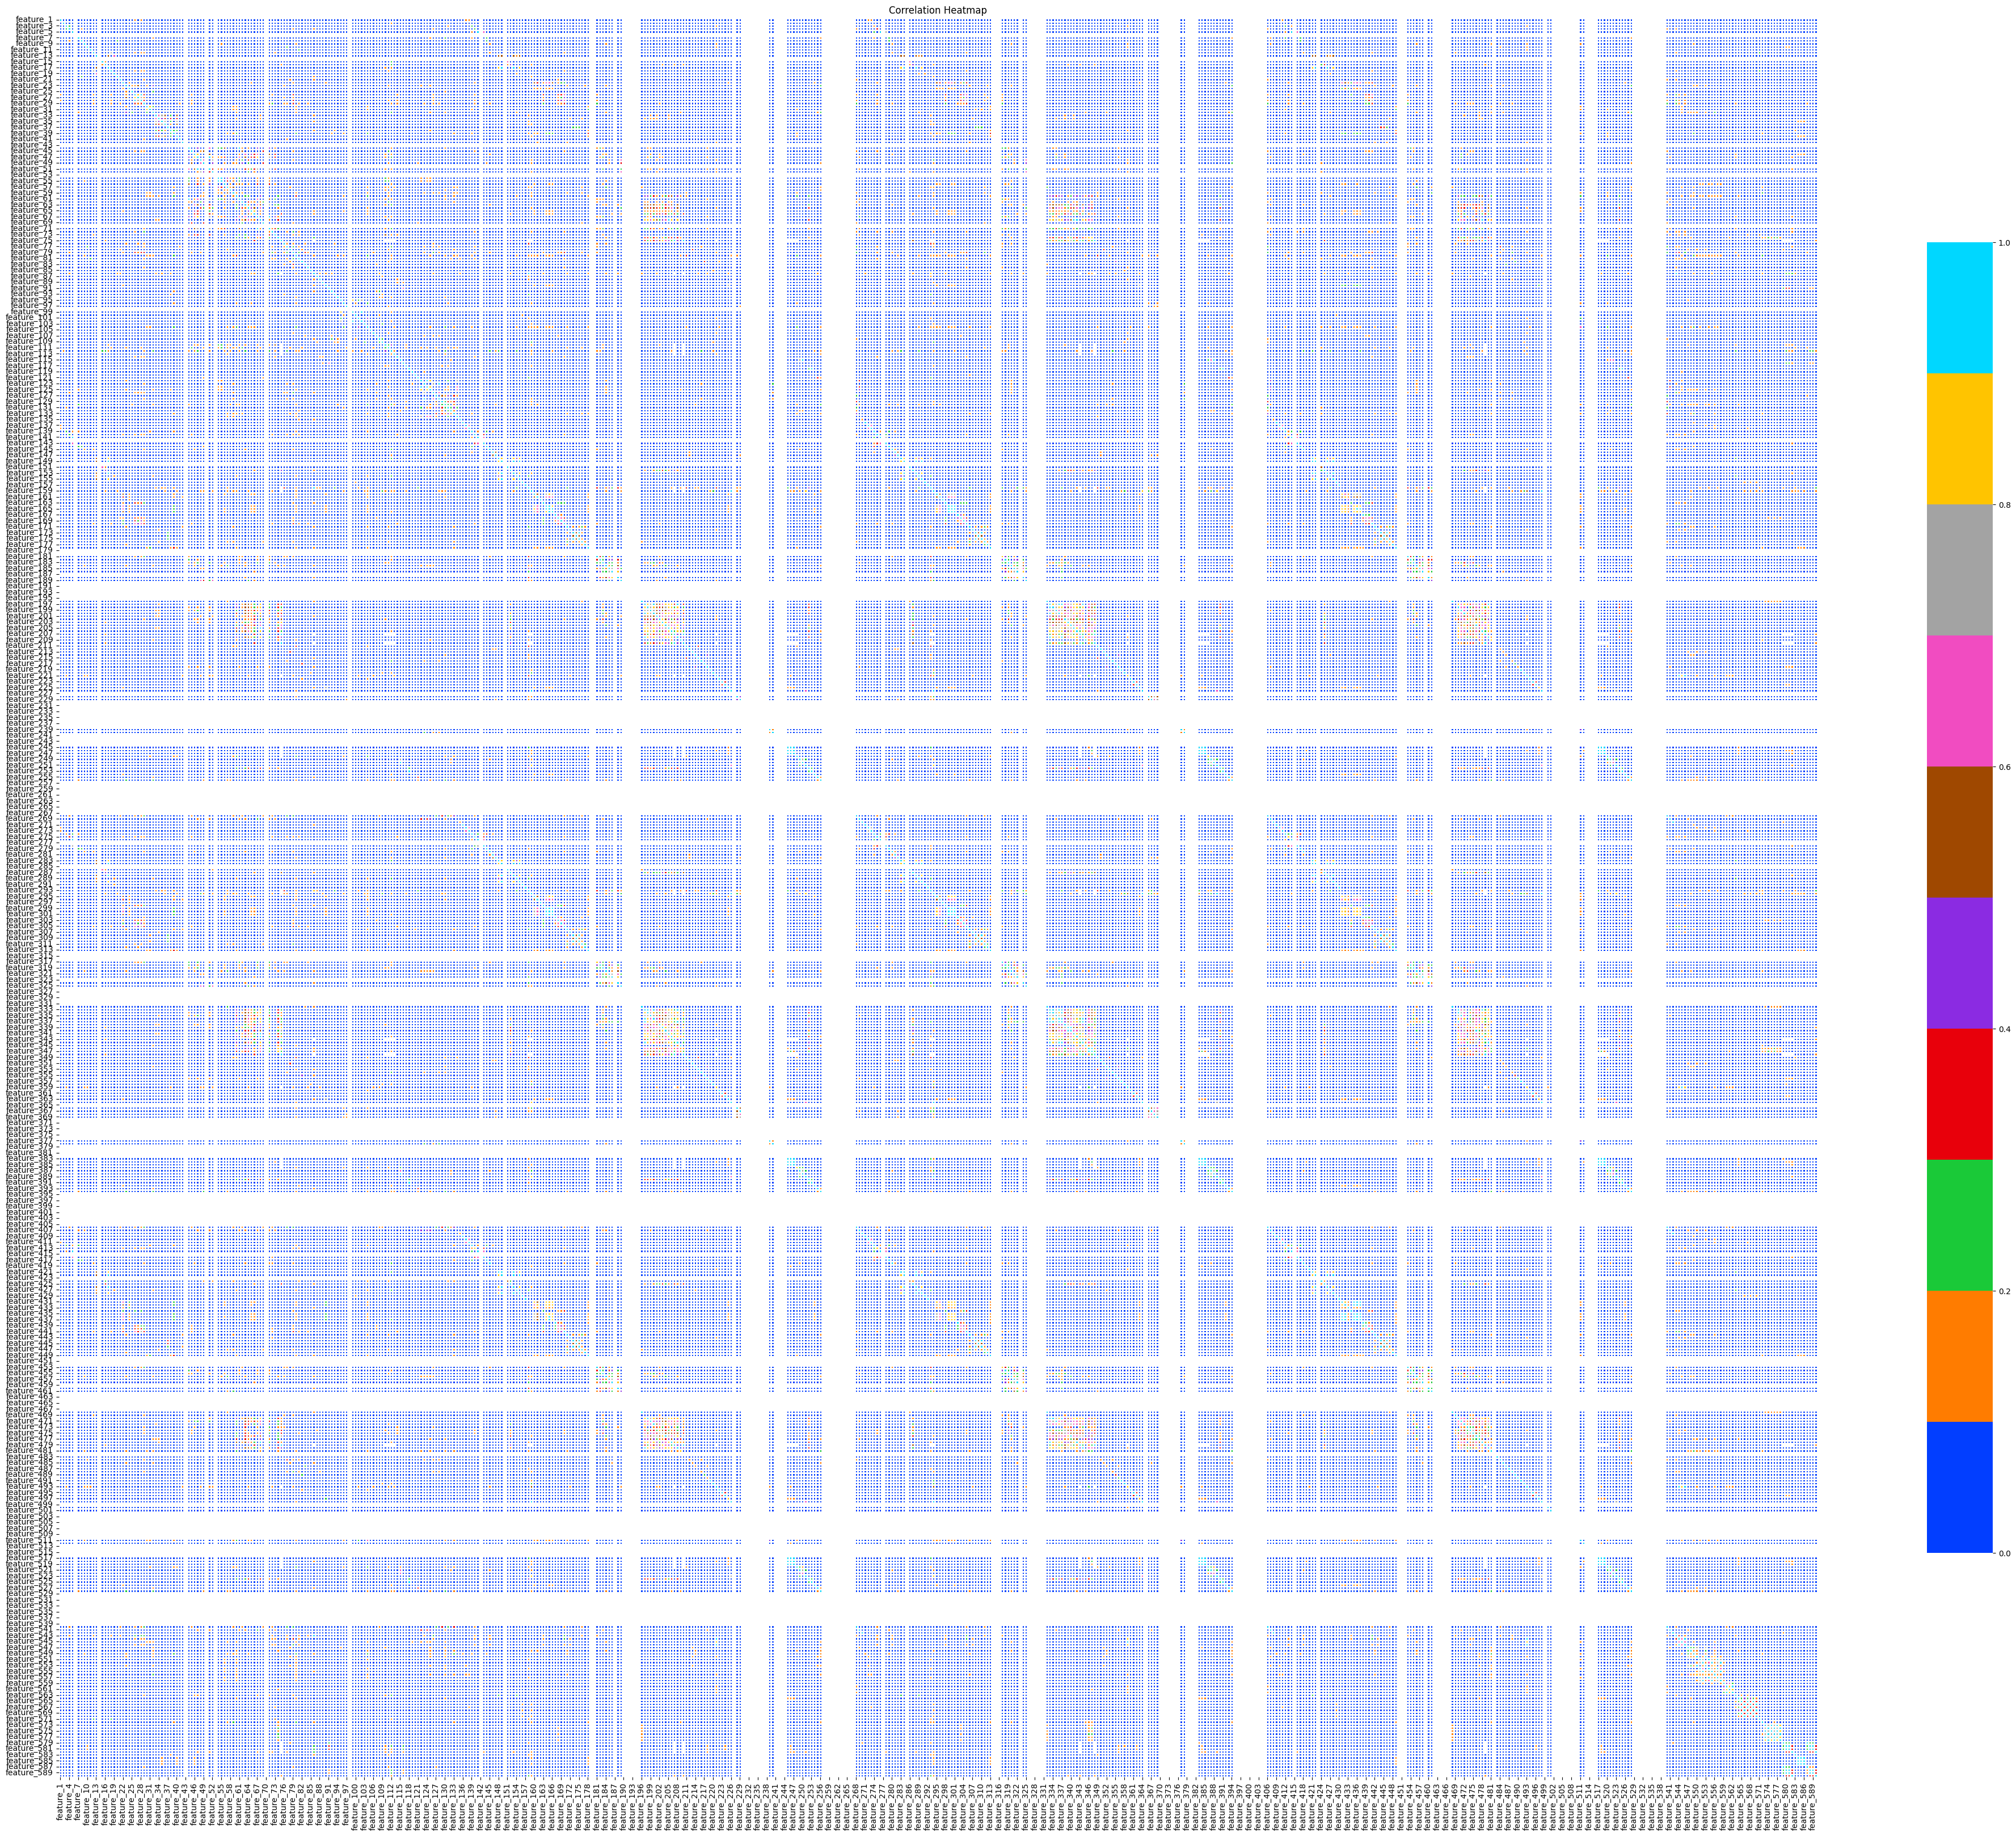

Number of pairs with correlation >= 0.8: 623.0
Number of distinct features in high correlation pairs: 474




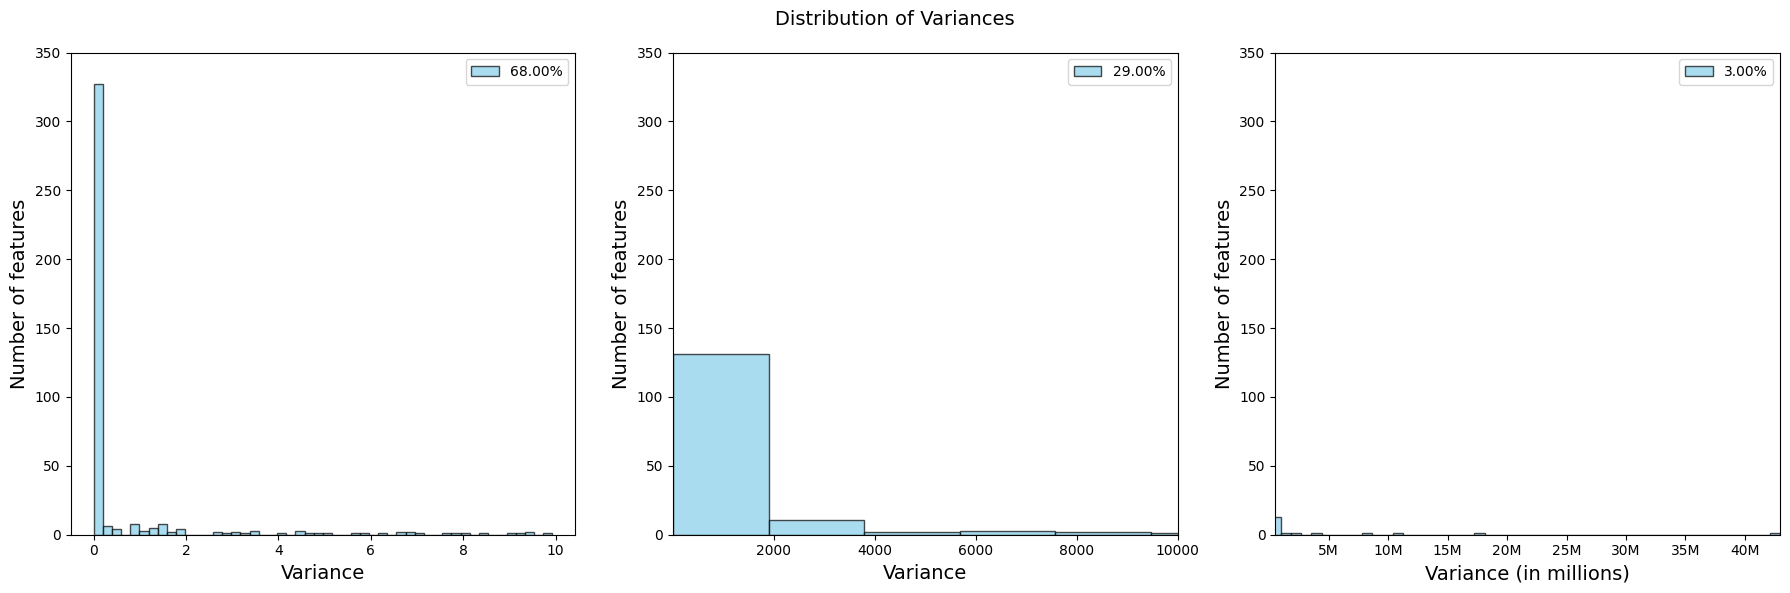

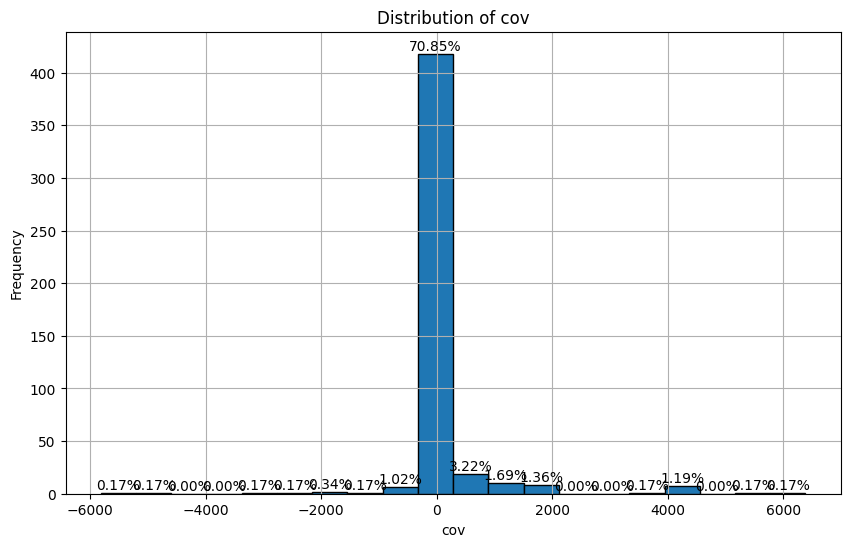



╒════════╤═════════╤═════════════╤════════════════╕
│        │   value │   frequency │ feature_name   │
╞════════╪═════════╪═════════════╪════════════════╡
│  63557 │  0      │        1560 │ feature_75     │
├────────┼─────────┼─────────────┼────────────────┤
│  63558 │  4.1955 │           1 │ feature_75     │
├────────┼─────────┼─────────────┼────────────────┤
│ 137199 │  0      │        1560 │ feature_207    │
├────────┼─────────┼─────────────┼────────────────┤
│ 137200 │  2      │           1 │ feature_207    │
├────────┼─────────┼─────────────┼────────────────┤
│ 139796 │  0      │        1560 │ feature_210    │
├────────┼─────────┼─────────────┼────────────────┤
│ 139797 │ 46.15   │           1 │ feature_210    │
├────────┼─────────┼─────────────┼────────────────┤
│ 215140 │  0      │        1560 │ feature_343    │
├────────┼─────────┼─────────────┼────────────────┤
│ 215141 │  0.4472 │           1 │ feature_343    │
├────────┼─────────┼─────────────┼────────────────┤
│ 219763 │

In [37]:
preprocess_secom_data()

In [38]:
# Step 15: Separate secom_main into training data set and test set

# Slice secom_main to exclude the pass_fail_flag column, and timestamp column from feature_1 to feature_590
X = secom_main.loc[:, 'feature_1':]
# Slice secom_main to include only pass_fail_flag column
y = secom_main['pass_fail_flag']

# Stratifiedly sepate 25% of secom_main into a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# Check the amount of fail and pass in the training and test set
print('Number of passing features in the training set =', y_train.value_counts()[1])
print('Number of failing features in the training set =', y_train.value_counts()[-1])
print('Number of passing features in the test set =', y_test.value_counts()[1])
print('Number of failing features in the test set =', y_test.value_counts()[-1])

Number of passing features in the training set = 78
Number of failing features in the training set = 1097
Number of passing features in the test set = 26
Number of failing features in the test set = 366


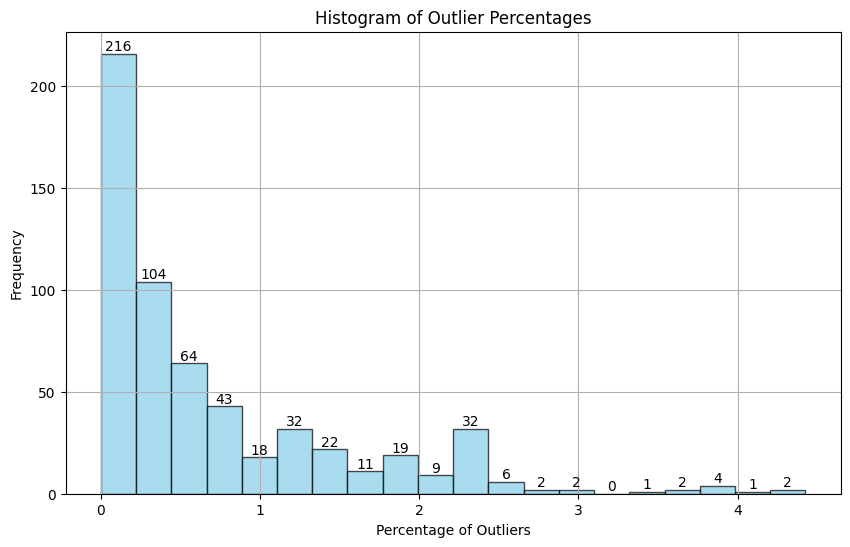

In [39]:
# Step 16: Identify outliers in the training set

#Calculate mean and standard deviation of the training set
means = X_train.mean()
std_devs = X_train.std()

#Identify outliers by the 3S rule
outliers = (X_train < (means - 3 * std_devs)) | (X_train > (means + 3 * std_devs))

# Count how many features have outliers
num_features_with_outliers = np.sum(outliers.any(axis=0))

# Indices of features with outliers
outlier_indices = np.where(outliers.any(axis=0))[0]

# Count how many outliers are detected within each feature
num_outliers_per_feature = np.sum(outliers, axis=0)

# Calculate percentage of outliers within each feature
percentage_outliers_per_feature = (num_outliers_per_feature / len(X_train)) * 100

# Plot histogram of outlier percentages
plt.figure(figsize=(10, 6))
counts, bin_edges, _ = plt.hist(percentage_outliers_per_feature, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels for each bar
for i in range(len(counts)):
    plt.text(bin_edges[i] + (bin_edges[i+1] - bin_edges[i]) / 2, counts[i],
             f'{int(counts[i])}', ha='center', va='bottom')

# Add labels and title
plt.title('Histogram of Outlier Percentages')
plt.xlabel('Percentage of Outliers')
plt.ylabel('Frequency')

# Add grid
plt.grid(True)

# Show the plot
plt.show()